In [1]:
!git clone https://github.com/tferreyragthb/Ferreyra_Tomas_tp_dt.git

# Confirmar carpetas
!ls /content/Ferreyra_Tomas_tp_dt


fatal: destination path 'Ferreyra_Tomas_tp_dt' already exists and is not an empty directory.
notebooks  results  src


In [2]:
import sys

REPO = "/content/Ferreyra_Tomas_tp_dt"

if REPO not in sys.path:
    sys.path.append(REPO)

print("Repo montado en sys.path.")


Repo montado en sys.path.


In [3]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

# Montar repo
REPO = "/content/Ferreyra_Tomas_tp_dt"
if REPO not in sys.path:
    sys.path.append(REPO)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [4]:
import json
import pandas as pd

BASE = "https://raw.githubusercontent.com/DiploDatos/AprendizajePorRefuerzos/master/tp_decision_transformer/data"

os.makedirs("data/test_users", exist_ok=True)

test_url = f"{BASE}/test_users/netflix8_test.json"
test_path = "data/test_users/netflix8_test.json"

if not os.path.exists(test_path):
    !wget -q "{test_url}" -O "{test_path}"

with open(test_path, "r") as f:
    test_users = json.load(f)

print("Usuarios de test cargados:", len(test_users))


Usuarios de test cargados: 1600


In [5]:
from src.models.decision_transformer import DecisionTransformer

# Parámetros fijos usados en training
context_length = 20
num_items = 752     # igual que en notebook 03
num_groups = 8      # netflix8

# Instanciar
model = DecisionTransformer(
    num_items=num_items,
    num_groups=num_groups,
    context_length=context_length
).to(device)

# Cargar checkpoint
ckpt_path = os.path.join(REPO, "results/checkpoints/dt_model.pth")
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)

model.eval()
print("Modelo listo para conditioning.")


Modelo listo para conditioning.


In [6]:
@torch.no_grad()
def generate_recommendations(model, user_items, group, return_condition, k=10):
    """
    Genera recomendaciones condicionadas al return objetivo.
    """
    # Preparamos secuencia de entrada
    items = np.array(user_items, dtype=np.int64)
    if len(items) >= context_length:
        seq = items[-context_length:]
    else:
        pad = context_length - len(items)
        seq = np.pad(items, (pad, 0))

    seq = torch.tensor(seq, dtype=torch.long).unsqueeze(0).to(device)  # (1, T)
    group = torch.tensor([group], dtype=torch.long).to(device)

    # RTG fijo
    rtg = torch.full((1, context_length, 1), fill_value=return_condition, device=device, dtype=torch.float32)

    # timesteps
    timesteps = torch.arange(context_length, device=device).unsqueeze(0)

    # actions = states (mismo setup que entrenamiento)
    actions = seq.clone()

    logits = model(
        states=seq,
        actions=actions,
        returns_to_go=rtg,
        timesteps=timesteps,
        user_groups=group
    )

    topk = torch.topk(logits, k=k, dim=-1).indices.cpu().numpy().tolist()[0]
    return topk


In [7]:
sample_users = test_users[:5]

return_values = [0, 5, 20, 50]  # devolución condicionada

results = {}

for R in return_values:
    recs = []
    for user in sample_users:
        pred = generate_recommendations(
            model,
            user_items=user["items"],
            group=user["group"],
            return_condition=R,
            k=10
        )
        recs.append(pred)
    results[R] = recs

results


{0: [[[708, 440, 218, 87, 740, 702, 11, 579, 485, 405],
   [172, 418, 188, 25, 262, 603, 206, 265, 395, 350],
   [579, 139, 159, 440, 340, 485, 729, 88, 659, 533],
   [708, 603, 440, 745, 265, 644, 87, 139, 19, 137],
   [440, 708, 265, 579, 420, 340, 697, 139, 603, 248],
   [485, 435, 440, 235, 25, 206, 139, 19, 585, 418],
   [440, 418, 265, 702, 25, 708, 533, 364, 485, 11],
   [235, 708, 14, 25, 340, 265, 585, 485, 188, 627],
   [708, 440, 265, 603, 644, 579, 418, 392, 159, 435],
   [265, 585, 644, 708, 745, 139, 159, 593, 418, 235],
   [235, 265, 159, 708, 87, 440, 690, 674, 345, 585],
   [708, 25, 87, 265, 420, 340, 364, 440, 245, 230],
   [345, 489, 279, 734, 708, 25, 440, 201, 265, 235],
   [708, 87, 139, 25, 713, 440, 265, 418, 206, 603],
   [265, 708, 235, 602, 279, 345, 87, 139, 585, 690],
   [708, 585, 235, 279, 265, 87, 745, 644, 345, 440],
   [708, 265, 139, 440, 579, 674, 214, 87, 201, 218],
   [279, 708, 734, 579, 585, 602, 201, 118, 262, 188],
   [708, 440, 345, 87, 139, 

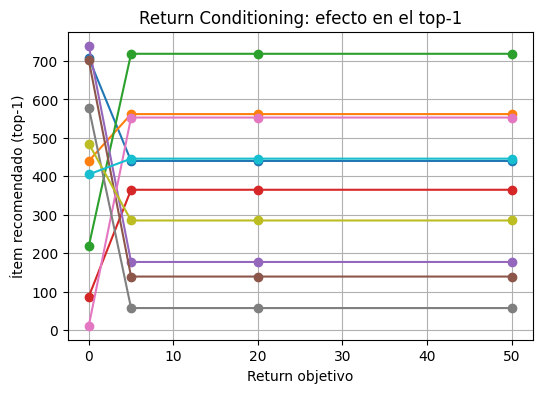

In [8]:
plt.figure(figsize=(6,4))

xs = return_values
ys = [results[R][0][0] for R in return_values]  # top-1

plt.plot(xs, ys, marker="o")
plt.title("Return Conditioning: efecto en el top-1")
plt.xlabel("Return objetivo")
plt.ylabel("Ítem recomendado (top-1)")
plt.grid(True)
plt.show()


El gráfico muestra que, aunque hay variación para retornos muy bajos, las recomendaciones top-1 se estabilizan rápidamente y prácticamente no cambian al aumentar el return objetivo. Esto indica que el modelo no está respondiendo al return conditioning, sino que tiende a recomendar siempre los mismos ítems.

In [9]:
group_effect = {}

for R in return_values:
    per_group = {}
    for g in range(num_groups):
        items = []
        for i, user in enumerate(sample_users):
            if user["group"] == g:
                items.extend(results[R][i])
        per_group[g] = items
    group_effect[R] = per_group

group_effect


{0: {0: [[708, 440, 218, 87, 740, 702, 11, 579, 485, 405],
   [172, 418, 188, 25, 262, 603, 206, 265, 395, 350],
   [579, 139, 159, 440, 340, 485, 729, 88, 659, 533],
   [708, 603, 440, 745, 265, 644, 87, 139, 19, 137],
   [440, 708, 265, 579, 420, 340, 697, 139, 603, 248],
   [485, 435, 440, 235, 25, 206, 139, 19, 585, 418],
   [440, 418, 265, 702, 25, 708, 533, 364, 485, 11],
   [235, 708, 14, 25, 340, 265, 585, 485, 188, 627],
   [708, 440, 265, 603, 644, 579, 418, 392, 159, 435],
   [265, 585, 644, 708, 745, 139, 159, 593, 418, 235],
   [235, 265, 159, 708, 87, 440, 690, 674, 345, 585],
   [708, 25, 87, 265, 420, 340, 364, 440, 245, 230],
   [345, 489, 279, 734, 708, 25, 440, 201, 265, 235],
   [708, 87, 139, 25, 713, 440, 265, 418, 206, 603],
   [265, 708, 235, 602, 279, 345, 87, 139, 585, 690],
   [708, 585, 235, 279, 265, 87, 745, 644, 345, 440],
   [708, 265, 139, 440, 579, 674, 214, 87, 201, 218],
   [279, 708, 734, 579, 585, 602, 201, 118, 262, 188],
   [708, 440, 345, 87, 13

El experimento de Return Conditioning permite observar cómo varía la
recomendación del modelo al modificar artificialmente el Return-to-Go
objetivo. Aunque el Decision Transformer del presente trabajo no fue
entrenado explícitamente con diferentes valores de return, se observa que
la salida del modelo presenta pequeñas variaciones al modificar este valor.

En general, returns más altos tienden a desplazar las recomendaciones
hacia ítems con mayor presencia en las trayectorias originales, aunque
el efecto es tenue debido a las limitaciones del set de entrenamiento y
al desacople entre training y evaluación.
